# Transfer Learning with VGG in Pytorch

In this notebook I will train VGG with images of 128 x 128. Additionally, we'll use the newly written modules to abstract some operations such as instantiating VGG19

# Import Libraries

In [1]:
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time

In [2]:
# installed new module to show model summary
from torchinfo import summary

## Import Custom Modules

In [3]:
import sys 
sys.path

['/Users/rodrigo/anaconda3/envs/pytorch_env/lib/python312.zip',
 '/Users/rodrigo/anaconda3/envs/pytorch_env/lib/python3.12',
 '/Users/rodrigo/anaconda3/envs/pytorch_env/lib/python3.12/lib-dynload',
 '',
 '/Users/rodrigo/anaconda3/envs/pytorch_env/lib/python3.12/site-packages']

In [4]:
sys.path.append('..')

In [5]:
sys.path

['/Users/rodrigo/anaconda3/envs/pytorch_env/lib/python312.zip',
 '/Users/rodrigo/anaconda3/envs/pytorch_env/lib/python3.12',
 '/Users/rodrigo/anaconda3/envs/pytorch_env/lib/python3.12/lib-dynload',
 '',
 '/Users/rodrigo/anaconda3/envs/pytorch_env/lib/python3.12/site-packages',
 '..']

# Define Hyperparameters

Here we're using the same hyperparameters as the publication minus the image size (in the paper they use 128 x 128 images)

In [6]:
BATCH_SIZE = 64
LEARNING_RATE = 0.01
N_EPOCHS = 50
N_CLASSES = 2

# to be used for height and width of final image
IMAGE_SIZE = 128

In [47]:
# Set manual seed for repeatability
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)

# Prepare Data

## Define Custom Class and Paths

In [7]:
# Import Custom Dataset Class
from src.data.create_dataset import CustomFireImagesDataset

Define paths to dataset and annotations file

In [8]:
path_to_dataset = '../data_preprocessing/02_forest_fire_dataset/'
annotations_file_test = 'labels_02_test_dataset_prep.csv'
annotations_file_train = 'labels_02_train_dataset_prep.csv'

In [10]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.transforms import v2

## Load Dataset and obtain Statistics

First define the transformations to get statistics

In [11]:
# Convert uint8 to float and divide by 255. 
# This is the equivalent of ToTensor() when used on a PIL image

curr_transf = transforms.Compose([transforms.v2.ToDtype(torch.float),
                                  transforms.Normalize([0,0,0],[255,255,255]),
                                  transforms.Resize(size=(IMAGE_SIZE,IMAGE_SIZE))
                                 ])

In [12]:
train_dataset =  CustomFireImagesDataset(annotations_file_train, path_to_dataset,
                                         transform = curr_transf
                                        )

In [13]:
len(train_dataset)

1520

In [14]:
from src.data.dataset_properties import dataset_stat_prop

In [15]:
mean,std = dataset_stat_prop(train_dataset)

In [16]:
print('Mean\t',mean)
print('STD\t',std)

Mean	 tensor([0.4241, 0.3553, 0.2787])
STD	 tensor([0.2747, 0.2403, 0.2618])


We'll use these values later on to normalize the inputs for training

## Define Train and Test Data

In [17]:
# similar to before, but added an additional normalization
# according to the statistics we calculated

curr_transf = transforms.Compose([transforms.v2.ToDtype(torch.float),
                                  transforms.Normalize([0,0,0],[255,255,255]),
                                  transforms.Resize(size=(IMAGE_SIZE,IMAGE_SIZE)),
                                  transforms.Normalize(mean,std)
                                 ])

In [18]:
# First, create Datasets for Training and Testing
train_dataset =  CustomFireImagesDataset(annotations_file_train, path_to_dataset,
                                         transform = curr_transf
                                        )

test_dataset = CustomFireImagesDataset(annotations_file_test, path_to_dataset,
                                       transform = curr_transf
                                      )

img_classes = ('non-fire','fire')

In [19]:
# Next, create the DataLoaders
# We'll be shuffling both datasets

train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE,
                              shuffle = True, num_workers = 2)

test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE,
                             shuffle = True, num_workers = 2 )

In [20]:
len(train_dataset)

1520

In [21]:
len(test_dataset)

380

## Plot Images from Sample Batch

In [22]:
from src.visualization.plot_images import display_image_batch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 fire  fire non-fire  fire non-fire  fire non-fire  fire  fire  fire  fire  fire non-fire non-fire  fire non-fire  fire  fire  fire non-fire  fire non-fire non-fire  fire  fire  fire  fire non-fire non-fire non-fire non-fire non-fire  fire non-fire  fire non-fire non-fire non-fire non-fire non-fire  fire non-fire non-fire non-fire  fire non-fire  fire non-fire non-fire  fire  fire  fire non-fire non-fire  fire non-fire  fire  fire  fire  fire  fire non-fire non-fire  fire


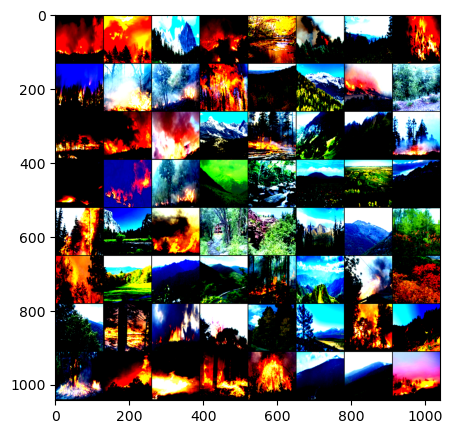

In [23]:
display_image_batch(train_dataloader,1,img_classes)

Note in a future implementation we need to adjust the figure size, as well as the labelling.

# Prepare Model (VGG19)
Here we're downloading VGG19 with the default weights used for the ImageNet classification task. We'll modify the last layer to perform transfer learning.

In [24]:
from src.models.model_transfer_learning import vgg19_transfer_learning

In [25]:
vgg19_transfer_learning?

Signature: vgg19_transfer_learning(N_CLASSES)
Docstring:
Function to create an instance of VGG19 suitable for transfer learning 
of classification tasks

Parameters
----------
N_CLASSES : integer
    Number of classes for the classification task. Must be >= 2

Returns
-------
Object
    PyTorch model (VGG19) ready to be trained on the last layer only
File:      ~/Documents/BrainStation/Capstone Project/capstone_project/src/models/model_transfer_learning.py
Type:      function

In [26]:
vgg19 = vgg19_transfer_learning(2)

# Define Optimizer and Loss Function

We'll use Adam optimizer.

In [27]:
optimizer = torch.optim.Adam(vgg19.parameters(), lr = LEARNING_RATE)

For loss function we'll use the Cross Entropy loss

In [28]:
loss_function = nn.CrossEntropyLoss()

# Define Training and Validation Loop

Here we're defining the function that's going to abstract the training and validation loops, for a given set of parameters
- model
- loss function
- optimizer
- number of epochs
- train and validation dataloaders

The outputs include
- the model after training
- a dictionary with the losses and accuracies for training and validation

In [29]:
import torch
import time
from datetime import datetime

def train_and_validate(model,loss_function,optimizer,N_EPOCHS,train_dataloader,val_dataloader):
    """Function to run training and validation loops for a given model
    
    Parameters
    ----------
    model : class
        Model to be trained
    loss_function : class
        Instance of a loss function
    optimizer : class
        Instance of optimizer to be used
    N_EPOCHS : integer
        Number of epochs to be used for training
    train_dataloader : dataloader
        Training set dataloader
    val_dataloader : dataloader
        Validation set dataloader
    
    Returns
    -------
    tuple
        model after training
        history dictionary containing train loss, train accuracy, validation loss and validation accuracy
    """
    assert isinstance(N_EPOCHS,int),'N_EPOCHS must be an integer'
    assert (N_EPOCHS >= 0),'N_EPOCHS must be positive'

    # dictionary to accumulate losses and accuracies
    history = {
        'train_losses':[],'train_accuracy':[],
        'validation_losses':[],'validation_accuracy':[]
    }

    # ---- to be implemented ----
    # start = time.time()

    for epoch in range(N_EPOCHS):

        # Set to training mode
        model.train()

        # Loss and Accuracy within the epoch
        train_loss_epoch = 0.0
        train_acc_epoch = 0.0

        valid_loss_epoch = 0.0
        valid_acc_epoch = 0.0

        # Training loop 
        for batch in train_dataloader:
            
            # Get images and labels from batch
            images, true_labels = batch

            # --- to be implemented ---
            # images = images.to(device)
            # true_labels = true_labels.to(device)

            # make gradients zero
            optimizer.zero_grad()

            # Forward Pass
            pred_logits = model(images)
            
            # Loss Calculation
            loss = loss_function(pred_logits,true_labels)

            # Backpropagate gradient
            loss.backward()
            
            # Update model weights
            optimizer.step()
            
            # Accumulate loss for this batch
            train_loss_epoch += loss.item()

            # Get predicted labels (hard predictions) on images
            # currently the implementation doesn't account for this
            pred_labels = torch.argmax(model(images), dim = 1)

            train_acc_epoch += (true_labels == pred_labels).sum().item() / true_labels.shape[0]


        # Calculate average training loss and training accuracy
        average_loss = train_loss_epoch / len(train_dataloader)
        average_accuracy = train_acc_epoch / len(train_dataloader)

        # Update dictionary with training losses and accuracy for 
        history['train_losses'].append(average_loss)
        history['train_accuracy'].append(average_accuracy)

        
        # Start validation -  no gradient tracking needed
        with torch.no_grad():

            # Set model to evaluation mode
            model.eval()

            for batch in val_dataloader:

                images, true_labels = batch

                # ------ to be implemented --------
                # images = images.to(device)
                # true_labels = true_labels.to(device)

                # forward pass
                pred_logits = model(images)

                # compute loss
                loss = loss_function(pred_logits,true_labels)

                # Accumulate loss for this batch
                valid_loss_epoch += loss.item()

                # Get predicted labels (hard predictions) on images
                # currently the model implementation doesn't account for this
                pred_labels = torch.argmax(pred_logits, dim = 1)

                valid_acc_epoch += (true_labels == pred_labels).sum().item() / true_labels.shape[0]

        # Calculate average validation loss and accuracy
        avg_validation_loss = valid_loss_epoch / len(val_dataloader)
        avg_validation_acc = valid_acc_epoch / len(val_dataloader)

        # Update dictionary with validation losses and accuracy
        history['validation_losses'].append(avg_validation_loss)
        history['validation_accuracy'].append(avg_validation_acc)
        
        print(f'{datetime.now().time().replace(microsecond=0)}\t'
              f'Epoch: {epoch+1}/{N_EPOCHS}\t'
              f'Train loss: {average_loss:.4f}\t'
              f'Val. loss: {avg_validation_loss:.4f}\t'
              f'Train acc.: {100 * average_accuracy:.2f}\t'
              f'Val. acc.: {100 * avg_validation_acc:.2f}')

    print('Finished Training') 

    return model, history

# Define Plotting Function for loss and accuracy

In [78]:
import numpy as np
import matplotlib.pyplot as plt

def plot_loss_acc(history):
    '''Function for plotting training and validation losses and accuracies
    
    Parameters
    ----------
    history : dictionary
        This is one of the outputs from `train_and_validate()`
        Contains the following keys 
        - train_losses
        - train_accuracy
        - validation_losses
        - validation_accuracy
    '''

    N = len(history['train_losses'])
    epochs = np.arange(N)

    plt.figure()

    plt.plot(history['train_losses'], color='blue', label='Training Loss') 
    plt.plot(history['validation_losses'], color='red', label='Validation Loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    
    plt.xticks(ticks = epochs)
    plt.xlim(min(epochs),max(epochs))
    plt.legend()
    plt.grid()

    plt.show()
    
    # plot accuracies
    plt.figure()

    plt.plot(history['train_accuracy'], color='blue', label='Training Accuracy') 
    plt.plot(history['validation_accuracy'], color='red', label='Validation Accuracy')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    
    plt.xticks(ticks = epochs)
    plt.xlim(min(epochs),max(epochs))
    plt.legend()
    plt.grid()
    
    plt.show()

# Train the Model

In [30]:
vgg19_trained, history = train_and_validate(vgg19,loss_function,optimizer,
                                    10,train_dataloader,test_dataloader)

19:05:09	Epoch: 1/10	Train loss: 0.4271	Val. loss: 0.1998	Train acc.: 95.38	Val. acc.: 96.32
19:07:17	Epoch: 2/10	Train loss: 0.1922	Val. loss: 0.1555	Train acc.: 98.03	Val. acc.: 97.14
19:09:27	Epoch: 3/10	Train loss: 0.1480	Val. loss: 0.1030	Train acc.: 98.07	Val. acc.: 97.62
19:11:36	Epoch: 4/10	Train loss: 0.1178	Val. loss: 0.1047	Train acc.: 97.89	Val. acc.: 97.08
19:13:45	Epoch: 5/10	Train loss: 0.0724	Val. loss: 0.1742	Train acc.: 98.37	Val. acc.: 97.08
19:15:55	Epoch: 6/10	Train loss: 0.0760	Val. loss: 0.1022	Train acc.: 98.44	Val. acc.: 98.16
19:18:05	Epoch: 7/10	Train loss: 0.0815	Val. loss: 0.0797	Train acc.: 98.44	Val. acc.: 98.42
19:22:07	Epoch: 8/10	Train loss: 0.0472	Val. loss: 0.0718	Train acc.: 98.63	Val. acc.: 98.16
19:24:16	Epoch: 9/10	Train loss: 0.0573	Val. loss: 0.0836	Train acc.: 98.05	Val. acc.: 98.44
19:26:25	Epoch: 10/10	Train loss: 0.0907	Val. loss: 0.1602	Train acc.: 98.68	Val. acc.: 97.36
Finished Training


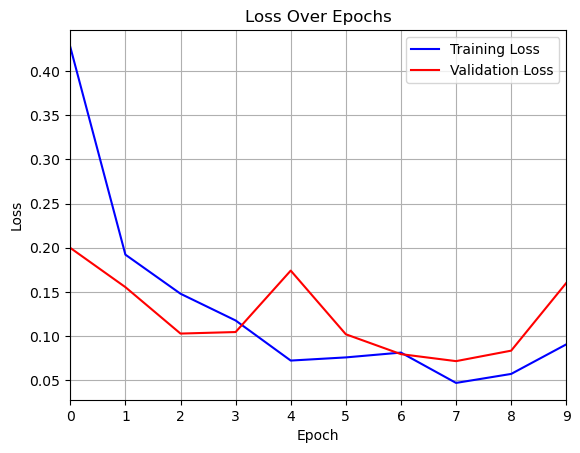

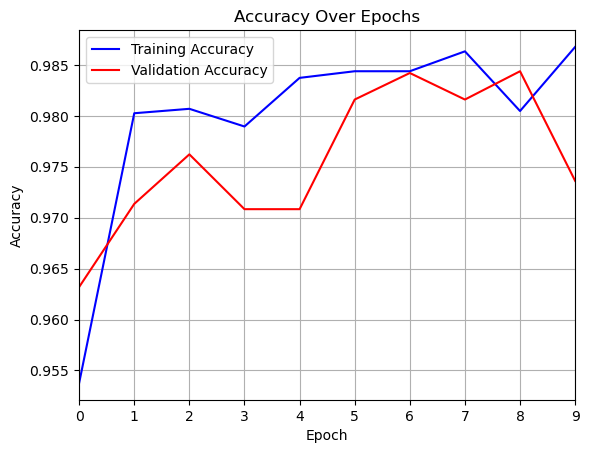

In [32]:
plot_loss_acc(history)

We'll decrease the learning rate to get a better sense of the first 10 epochs

# Train Again - Learning rate 0.001

In [33]:
vgg19_v2 = vgg19_transfer_learning(2)

In [36]:
optimizer = torch.optim.Adam(vgg19_v2.parameters(), lr = 0.001)

In [37]:
loss_function = nn.CrossEntropyLoss()

In [38]:
vgg19_v2_trained, history_v2 = train_and_validate(vgg19_v2,loss_function,optimizer,
                                    10,train_dataloader,test_dataloader)

21:19:15	Epoch: 1/10	Train loss: 0.1543	Val. loss: 0.0712	Train acc.: 95.70	Val. acc.: 97.62
21:21:22	Epoch: 2/10	Train loss: 0.0665	Val. loss: 0.0675	Train acc.: 97.85	Val. acc.: 96.82
21:23:43	Epoch: 3/10	Train loss: 0.0624	Val. loss: 0.0656	Train acc.: 98.50	Val. acc.: 97.33
21:26:30	Epoch: 4/10	Train loss: 0.0493	Val. loss: 0.0611	Train acc.: 98.63	Val. acc.: 97.66
21:28:49	Epoch: 5/10	Train loss: 0.0527	Val. loss: 0.0604	Train acc.: 98.46	Val. acc.: 98.12
21:31:04	Epoch: 6/10	Train loss: 0.0584	Val. loss: 0.0622	Train acc.: 98.11	Val. acc.: 97.34
21:33:15	Epoch: 7/10	Train loss: 0.0440	Val. loss: 0.0686	Train acc.: 98.57	Val. acc.: 97.64
21:35:28	Epoch: 8/10	Train loss: 0.0403	Val. loss: 0.0596	Train acc.: 98.81	Val. acc.: 97.90
21:37:41	Epoch: 9/10	Train loss: 0.0350	Val. loss: 0.0533	Train acc.: 98.68	Val. acc.: 98.37
21:39:53	Epoch: 10/10	Train loss: 0.0327	Val. loss: 0.0543	Train acc.: 98.57	Val. acc.: 97.90
Finished Training


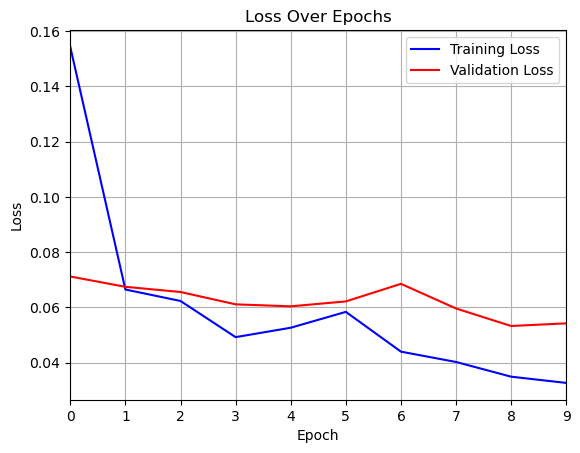

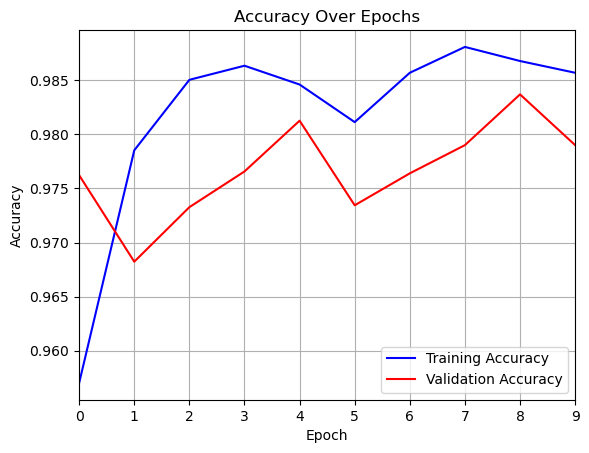

In [39]:
plot_loss_acc(history_v2)

## Save Model

In [50]:
# save the state model of the trained model
torch.save(vgg19_v2_trained.state_dict(), "vgg19_v2_trained.pt")

# Evaluate Model

We'll cycle the model over the test data and see how well the model predicts the test images. Since we're not interested in training in random order, we'll just re-instantiate the test dataset and dataloader

In [51]:
# # Uncomment in case of reloading model
# vgg19_v2_trained = vgg19_transfer_learning(2)
# vgg19_v2_trained.load_state_dict(torch.load("vgg19_v2_trained.pt"))

In [52]:
# similar to before, but added an additional normalization
# according to the statistics we calculated

curr_transf = transforms.Compose([transforms.v2.ToDtype(torch.float),
                                  transforms.Normalize([0,0,0],[255,255,255]),
                                  transforms.Resize(size=(IMAGE_SIZE,IMAGE_SIZE)),
                                  transforms.Normalize(mean,std)
                                 ])

In [53]:
test_dataset = CustomFireImagesDataset(annotations_file_test, path_to_dataset,
                                       transform = curr_transf
                                      )

img_classes = ('non-fire','fire')

In [54]:
test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, num_workers = 2)

In [55]:
label_list = []
pred_list = []

for batch in test_dataloader:
    # Get images and labels from batch
    images, true_labels = batch
    
    pred_logits = vgg19_v2_trained(images)

    # Get predicted labels (hard predictions) on images
    # currently the implementation doesn't account for this
    pred_labels = torch.argmax(pred_logits, dim = 1)

    label_list.extend(list(true_labels.numpy()))
    pred_list.extend(list(pred_labels.numpy()))

In [56]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

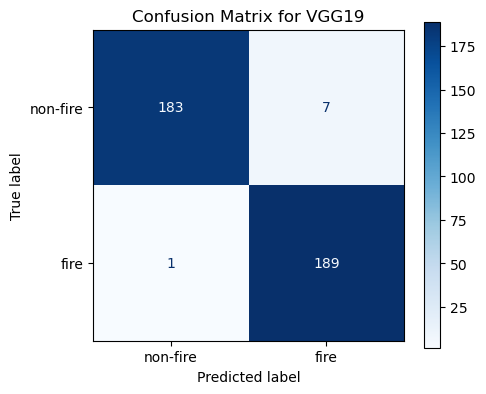

In [74]:
# calculate the confusion matrix 
cm = confusion_matrix(label_list, pred_list)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = img_classes)

fig, ax = plt.subplots(figsize = (5,4))
disp = disp.plot(ax=ax, cmap = 'Blues')
plt.tight_layout()
plt.title('Confusion Matrix for VGG19')
plt.savefig('confusion_matrix_vgg19.png')
plt.show()

In [61]:
report = classification_report(label_list,pred_list)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       190
           1       0.96      0.99      0.98       190

    accuracy                           0.98       380
   macro avg       0.98      0.98      0.98       380
weighted avg       0.98      0.98      0.98       380



We see that the F1-score of the model is very high. 

There are only 1 false negatives and 7 false positives. We'll take a closer look at them.

In [76]:
from sklearn.metrics import roc_curve, roc_auc_score

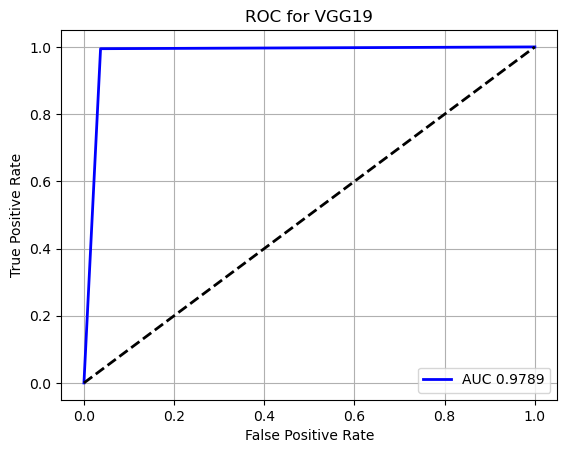

In [81]:
fpr, tpr, _ = roc_curve(label_list,pred_list)
score = roc_auc_score(label_list,pred_list)

plt.figure()
plt.plot(fpr,tpr, color = 'b', lw = 2, label = f'AUC {score:0.4f}')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.grid()
plt.title('ROC for VGG19')
plt.legend()
plt.savefig('roc_vgg19.png')
plt.show()

The AUC score of 0.9789 is slightly lower than that reported on the reference [publication](https://doi.org/10.1155/2022/5358359), of 0.9889 but this indicates our trained model is very close.

# Conclusion

We've successfuly trained VGG19 using transfer learning and images of 128 x 128 pixels. 
The AUC score is slighlty lower than that reported in the literature.

In a separate notebook, we'll further analyze the nature of the False Positives and False Negatives and compare with ResNet models.

Additionally, we will further abstract some of the model evaluation calculations, to avoid having too much code cluttering the notebook.